# Simulating Chaos

In this example, we will use REBOUND to integrate a chaotic planetary system. Let's import REBOUND first.

In [2]:
import rebound
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt

We now create the initial conditions. Often planetary systems which are close to a resonance are chaotic, so we have to find a system near a resonance. The easiest way to get planets into resonance is migration. So that's what we'll do. Initially we setup a simulation in which the planets are placed just outside the 2:1 mean motion resonance.

In [3]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-3,a=1,e=0.001)
sim.add(m=0.,a=1.65)
sim.move_to_com()

We then define a simple migration force that will act on the outer planet. We implement it in python. This is relatively slow, but we only need to migrate the planet for a short time.

In [4]:
def migrationForce(reb_sim):
    tau = 40000.
    ps[2].ax -= ps[2].vx/tau
    ps[2].ay -= ps[2].vy/tau
    ps[2].az -= ps[2].vz/tau

Next, we link the additional migration forces to our REBOUND simulation and get the pointer to the particle array.

In [5]:
sim.additional_forces = migrationForce
ps = sim.particles

Then, we just integrate the system for 3000 time units, about 500 years in units where $G=1$.

In [6]:
sim.integrate(3000.)

We now have a system in resonance. We give one planet a small kick to get it out of resonance. We also turn of the migration forces and set the time back to 0. 

In [7]:
sim.particles[2].vx *= 1.0303
sim.t = 0.  
sim.additional_forces = 0

Let's have a quick look as to how the system looks like.

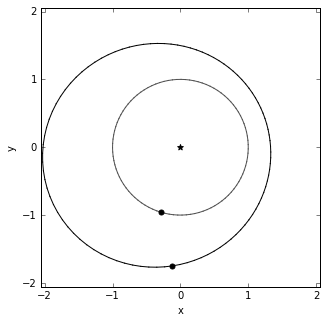

In [8]:
rebound.OrbitPlot(sim);

We can save the simulation to a binary file.

In [9]:
sim.save("resonant_system.bin") 

We can use the binary file to make a copy of our simulation. In the new copy, we shift the planet once again, but only by a very small amout, $10^{-11}$. If this were the Earth's orbit, this would correspond to moving the entire Earth by only 1 meter!

In [10]:
sim_shifted = rebound.Simulation.from_file("resonant_system.bin")
sim_shifted.particles[2].vx += 1e-11

We now integrate both simulations forward in time and meassure the distance between the outer planet 1000 times during the integration.

In [11]:
N = 1000
times = np.logspace(1,3.5,N)
distance = np.zeros(N)
for i,t in enumerate(times):
    sim.integrate(t)
    sim_shifted.integrate(t)
    dx = sim.particles[2].x - sim_shifted.particles[2].x
    dy = sim.particles[2].y - sim_shifted.particles[2].y
    dz = sim.particles[2].z - sim_shifted.particles[2].z
    distance[i] = np.sqrt(dx*dx+dy*dy+dz*dz)

We can now plot the distance of the two planets as a function of time. We do this is a log-linear plot, i.e. the vertical scale is logarithmic. This way, we can easily find out if the distance grows exponentially fast. If so, then the curve will be approximately a straight line. 

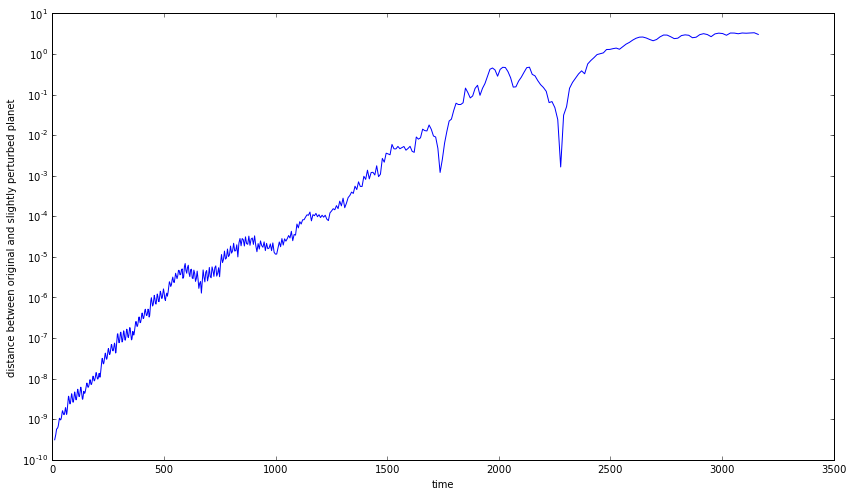

In [12]:
fig = plt.figure(figsize=(14,8))
ax = plt.subplot(111)
ax.set_yscale('log')
ax.set_xlabel("time"); ax.set_ylabel("distance between original and slightly perturbed planet")
p = ax.plot(times,distance)

As one can clearly see, the system is strongly chaotic. The initally small perturbation of $10^{-10}$ has grown to order unity very quickly. 